## Проект Предсказание поведения клиента

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. 
Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.
Нам предстоит выполнить инженеринг признаков, обучить и оптимизировать модель бинарной классификации, которая предскажет вероятность совершения покупки пользователем в течение 90 дней.

Цель: Предсказать вероятность покупки в течение 90 дней.

Метрикой в этом проекте является roc_auc.

Предоставленые данные включают следующие датасеты:

<b>apparel-purchases</b><br>
Данные о покупках клиентов по дням и по товарам. В каждой записи покупка
определенного товара, его цена, количество штук.
В него входят след. поля:
- <b>client_id</b> - идентификатор клиента
- <b>quantity</b> - количество единиц товара
- <b>price</b> - цена товара
- <b>category_ids</b> - идентификаторы категорий
- <b>date</b> - дата покупки
- <b>message_id</b> - идентификатор сообщения из рассылки


<b>apparel-messages</b>
Рассылки, которые были отправлены клиентам из таблицы покупок.
В него входят след. поля:
- <b>bulk_campaign_id</b> - идентификатор рассылки
- <b>client_id</b> - идентификатор клиента
- <b>message_id</b> - идентификатор сообщения
- <b>event</b> - действие с сообщением (отправлено, открыто, покупка…)
- <b>channel</b> - канал рассылки
- <b>date</b> - дата действия
- <b>created_at</b> - дата-время полностью


Целевой признак представлен <b>apparel-target_binary</b>, в нем содержится два поля:
- client_id идентификатор клиента
- target клиент совершил покупку в целевом периоде


<br>
В ходе работы выполним несколько шагов:
<ol style="list-style-type: none">
<li><a href='#section1'>1. Предобработка данных и генерация новых синтетических признаков</a>.</li>
Прочитаем данные, посмотрим на количество данных, количество пропущенных значений и формат представленных данных. Посмотрим, соответствуют ли они описанию задачи и стандартам оформления данных.
Проведем статистический анализ признаков. Построим графики признаков. Посмотрим есть ли выбросы в данных.
Попробуем избавиться от пропущенных значений если они есть, проверим наличие дубликатов.
Разработаем новые признаки.

<li><a href='#section2'>2. Проверка на мультиколлинеарность</a>.</li>
Посмотрим как данные связаны между собой и целевой переменной. На сонове это сделаем отбор набора обучающих признаков.

<li><a href='#section3'>3.Создадим пайплайн</a>.</li>
Разделим выборку на тестовую и тренировочную. Создадим пайплайн для обучения нашей модели.

<li><a href='#section4'>4. Обучение моделей</a>.</li>
Выберем и обучим несколько моделей. Для полученных модели сделаем оценку качества.
    
<li><a href='#section6'>5. Итоговый вывод</a></li>

</ol>

#### Загрузка необходимых библиотек

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score



from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier

from sklearn.preprocessing import (PolynomialFeatures, StandardScaler, 
                                   MinMaxScaler, OneHotEncoder, 
                                   OrdinalEncoder, LabelEncoder)

from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             recall_score, precision_score, accuracy_score,
                             roc_auc_score, mean_squared_error, f1_score, make_scorer)

from sklearn.inspection import permutation_importance


import phik
from phik.report import plot_correlation_matrix
# import shap
# from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

import os
import warnings
warnings.filterwarnings('ignore')

sns.set(style="darkgrid", font_scale=1)
pd.options.display.float_format = '{:_.4f}'.format

RANDOM_STATE = 42
TEST_SIZE = 0.15

# styles = [dict(selector="caption", props=[("text-align", "zero"),("font-size", "130%"),("font-weight", "bold")])]

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

#### Функции для отображение данных

In [14]:
def bar_plot_func_comp(df, col, num_col=10, hu=None, col_name=None, order_indx=None):
    plt.subplots(figsize=(6, 7))
    
    if order_indx:
        order_sort = df[col].value_counts().sort_index(ascending=False).index[:num_col]
    order_sort = df[col].value_counts().sort_values(ascending=False).index[:num_col]
        
    
    ax = sns.countplot(data=df,  
                     y=col,
                     edgecolor='black',
#                      width=0.85,
                     alpha = 0.75,
                     linewidth=1,
                     # gap=0.25,
                     hue=hu,
#                      orient='h',
                     order=order_sort
                    )
    for i in range(len(ax.containers)):
        ax.bar_label(ax.containers[i], fmt='%.0f', padding = 5, label_type='edge', color='black', size = 10);

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=0)
    ax.set_xlim(0,df[col].value_counts().values.max()*1.20)

    ax.set_xlabel('кол-во', fontsize=12, fontweight="bold")
    ax.set_ylabel('категория', fontsize=12, fontweight="bold")
    ax.set_title(col.upper(), fontsize=12, fontweight="bold")
    ax.legend(fontsize=14, loc=4)  


def bar_plor_func_(dt, x_name, y_name, title_name=None, num_col=10):
    plt.subplots(figsize=(16, 5))
    dt = dt.sort_values(by='Importance', ascending=False).sort_index(key=lambda x: x.map(custom_dict))

    ax = sns.barplot(data=dt,
                     x=x_name,
                     y=y_name,
                     errorbar=None,
                     edgecolor='black',
                     width=0.7,
                     alpha = 0.75,
                     linewidth=1,
                     # orient='v',
                     # gap=0.2,
                     order=dt[x_name][:num_col]
                    )
    for i in range(len(ax.containers)):
        ax.bar_label(ax.containers[i], fmt='%.0f', padding=5, label_type='edge', color='black', size = 11, rotation=90);
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=90)
    ax.set_ylim(0,dt[y_name].values.max()*1.3)
    ax.set_xlabel(x_name, fontsize=10, fontweight="bold")
    ax.set_ylabel(y_name, fontsize=10, fontweight="bold")
    if title_name:
        ax.set_title(title_name.upper(), fontsize=10, fontweight="bold")   

        


def bar_plor_func(dt, x_name, y_name, title_name=None, num_col=10, rond=0):
    plt.subplots(figsize=(16, 5))

    dt = pd.DataFrame(zip(dt.index, dt.values), columns=['признак','значение'])
    ax = sns.barplot(data=dt,
                     x='признак',
                     y='значение',
                     errorbar=None,
                     edgecolor='black',
                     width=0.7,
                     alpha = 0.75,
                     linewidth=1,
                     # orient='v',
                     # gap=0.2,
                     order=dt['признак'][:num_col]
                    )
    for i in range(len(ax.containers)):
        ax.bar_label(ax.containers[i], fmt=f'%.{rond}f', padding=5, label_type='edge', color='black', size = 11, rotation=90);
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=90)
    ax.set_ylim(0,dt['значение'].values.max()*1.3)
    # ax.set_title(f'Корреляция целевого признака')
    ax.set_xlabel(x_name, fontsize=10, fontweight="bold")
    ax.set_ylabel(y_name, fontsize=10, fontweight="bold")
    if title_name:
        ax.set_title(title_name.upper(), fontsize=10, fontweight="bold")    
        
        

def graph_num_plot(df, feature, bins=25):

    mean = df[feature].mean()
    median = np.median(df[feature])

    fig, axes = plt.subplots(1,2, figsize=(12, 3))


    axes[0].set_title('sasasa')
    ax1 = sns.histplot(data=df, 
                x=feature, 
                color='orange',
                kde=True,
                alpha = 0.9,
                edgecolor='b', 
                linewidth=1,
                # stat='density',
                line_kws={'lw': 1},
                bins=bins,
                ax=axes[0]
               )
    ax1.set_title(f'распределение')
    ax1.set_xlabel('')
    ax1.set_ylabel('Кол-во')
    ax1.lines[0].set_color('k')

    axes[0].axvline(mean, color='r', linewidth=2, linestyle='dashed', label=f'среднее - {mean:.4f}')
    axes[0].axvline(median, color='k', linewidth=2, label=f'медиана - {median:.4f}')

    ax2 = sns.boxplot(data=df, 
                x=feature, 
                color='orange', 
                ax=axes[1], 
                fliersize = 10,
                linewidth = 2,  # Lines width
                saturation = 0.95,
                width = 0.5,
                showmeans=True,
                meanline=True,
                meanprops={'color': 'r', 'ls': '--', 'lw': 3},
                # meanprops={'marker':'o',
                #            'markerfacecolor':'white', 
                #            'markeredgecolor':'black',
                #            'markersize':'8'}
                flierprops={'marker': 'o', 'markersize':5, 'markerfacecolor':'None'}
               )
    ax2.set_title(f'диаграмма размаха')
    ax2.set_xlabel('')
    fig.legend()
    fig.suptitle(feature.upper(), fontname="Comic Sans MS", fontsize=12, y=1.15, fontweight="bold")
    plt.show()

    
    
    
    
#Функция для построения графиков категориаль
def graph_cat_single_plot(df, fech, ax, ori='v', hue=None):
    
    if ori == 'v':
        axx = sns.countplot(data=df,
                                x=fech, 
                                order=df[fech].value_counts(dropna=False).index, 
                                saturation = 0.85,
                                # palette=pal,
                                hue=hue,
                                color='orange',
                                width=0.5,
                                orient='v',
                                edgecolor='b', 
                                linewidth=1,
                                ax=ax
                             )
        l = len(axx.patches)
        for n, p in enumerate(axx.patches):
            percentage = f'{p.get_height():,.0f}'
            width, height = p.get_width(),p.get_height()
            x=p.get_x()+width/2-0.1*((n+1)**0.7)
            y=p.get_y()+height+0.05*height
            ax.annotate(percentage,(x,y), fontsize=12, fontweight="bold")


        ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=0)
        ax.set_ylim(0,df[fech].value_counts().values.max()*1.30)
        # ax.set_title(f'Корреляция целевого признака')
        ax.set_xlabel('категория', fontsize=12, fontweight="bold")
        ax.set_ylabel('кол-во', fontsize=12, fontweight="bold")
        ax.set_title(fech.upper(), fontsize=12, fontweight="bold")
        
        
    else:
        axx = sns.countplot(data=df,
                        y=fech, 
                        order=df[fech].value_counts(dropna=False).index, 
                        saturation = 0.85,
                        # palette=pal,
                        hue=hue,
                        color='orange',
                        width=0.5,
                        edgecolor='b', 
                        linewidth=1,
                        ax=ax
                     )
        l = len(axx.patches)
        for n, p in enumerate(axx.patches):
            percentage = f'{p.get_width():,.0f}'
            width, height = p.get_width(),p.get_height()
            x=p.get_x()+width +0.05* width
            y=p.get_y()+height-0.1*((n+1)**0.1)
            ax.annotate(percentage,(x,y), fontsize=12, fontweight="bold")


        ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=35)
        ax.set_xlim(0,df[fech].value_counts().values.max()*1.30)
        # ax.set_title(f'Корреляция целевого признака')
        ax.set_ylabel('категория', fontsize=12, fontweight="bold")
        ax.set_xlabel('кол-во', fontsize=12, fontweight="bold")
        ax.set_title(fech.upper(), fontsize=12, fontweight="bold")

def corr_plor_func(dataset, xlim, title_name):
    m = pd.DataFrame(zip(dataset.index, dataset.values), columns=['признак','значение']).sort_values('значение', ascending=False)
    fig, ax = plt.subplots(figsize=(8, 5))
    pal = sns.color_palette("Oranges_r", len(dataset))
    # sns.set_color_codes("muted")
    axx = sns.barplot(data=m, 
                      y='признак', 
                      x='значение', 
                      saturation = 0.9,
                      palette=pal
                      # width=0.75,

                     )
    for p in axx.patches:
        percentage = f'{p.get_width():,.3f}'
        width, height = p.get_width(),p.get_height()
        x=p.get_x()+width+0.02
        y=p.get_y()+height/2+0.1
        ax.annotate(percentage,(x,y), fontsize=11, fontweight="bold")
    ax.set_xlim(xlim[0], xlim[1])
    # ax.set_title(f'Корреляция целевого признака')
    ax.set_xlabel('Коэф. корреляции', fontsize=12, fontweight="bold")
    ax.set_ylabel('Признак', fontsize=12, fontweight="bold")
    ax.lines[0].set_color('k')
    fig.suptitle(title_name.upper(), fontname="Comic Sans MS", fontsize=12, fontweight="bold");

<a id='section1'></a>

### 1. Предобработка данных и генерация новых синтетических признаков

Прочитаем данные, посмотрим на количество данных, количество пропущенных значений и формат представленных данных. Посмотрим, соответствуют ли они описанию задачи и стандартам оформления данных. При необходимости переименуем столбцы

Прочитаем наши данные

In [19]:
try:
    data_messages = pd.read_csv('/datasets/apparel-messages.csv')
    data_purchases = pd.read_csv('/datasets/apparel-purchases.csv')
    data_target = pd.read_csv('/datasets/apparel-target_binary.csv')
    print('The file exists global')
except:
    data_messages = pd.read_csv('apparel-messages.csv')
    data_purchases = pd.read_csv('apparel-purchases.csv')
    data_target = pd.read_csv('apparel-target_binary.csv')
    print('The file exists local')

The file exists local


Начнем с датасета <b>data_purchases</b>, посмотрим информацию по нему

In [21]:
data_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [22]:
data_purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1_999.0000,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2_499.0000,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6_499.0000,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4_999.0000,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4_999.0000,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


Столбец даты надо будет привести к правлильном формату. Посмотрим на уникальные значения по признакам. Начнем с признака <b>quantity</b>.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


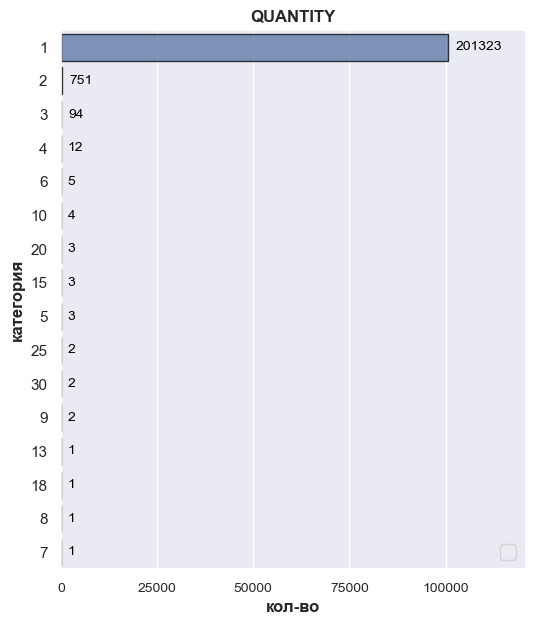

In [24]:
col='quantity'
bar_plot_func_comp(df=data_purchases, col=col, num_col=30)

In [25]:
f"Процент позиций с кол-м 1: {data_purchases.quantity.value_counts(normalize=True).values[0].round(4)}"

'Процент позиций с кол-м 1: 0.9956'

Большое кол-во покупок с одной позицией, почти 100%. Очень странно.

Посмотрим кол-во дубликатов

In [28]:
f"кол-во дубликатов: {data_purchases.duplicated().sum()}"

'кол-во дубликатов: 73020'

Очень много повторяющихся значений, посмотрим на парочку.

In [30]:
data_purchases[data_purchases.duplicated(keep=False)]

,client_id,quantity,price,category_ids,date,message_id
11,1515915625491869271,2,599.0000,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f
12,1515915625491869271,2,599.0000,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f
21,1515915625566606509,1,299.0000,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d
22,1515915625566606509,1,299.0000,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d
41,1515915625468070175,1,2_199.0000,"['4', '27', '142', '496']",2022-05-17,1515915625468070175-4439-6283414668daa
...,...,...,...,...,...,...
202201,1515915626010261344,1,1_499.0000,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202202,1515915626010261344,1,1_499.0000,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202203,1515915626010261344,1,1_499.0000,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202204,1515915626010439406,1,99.0000,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d


Большое кол-во дубликатов и то, что больше всего покупок идет в кол-ве 1, наводит на мысль, что чеки выбиваются по одной позиции и надо будет проссумировать одинаковые строки по кол-ву и сумме.

Посомтрим на след признак <b>category_ids</b>

In [33]:
data_purchases['category_ids'].value_counts()

category_ids
['4', '28', '57', '431']            8626
['4', '28', '260', '420']           6989
['4', '28', '244', '432']           6821
[]                                  5579
['4', '28', '275', '421']           4936
                                    ... 
['4', '5837', '5836', '839']           1
['5562', '5632', '5552', '1089']       1
['4', '27', '278', '471']              1
['5562', '5697', '5651', '1153']       1
['5562', '5597', '5696', '5529']       1
Name: count, Length: 933, dtype: int64

Сразу бросается в глаза наличие пустых категорий "[]". 
Категорий очень много, разобьем и посмотрим на значения первой категории.

In [35]:
data_purchases['category_ids'].replace(r'[\[\],]', '', regex=True).str.split(' ', expand=True)[0].value_counts(dropna=False)

0
'4'       112578
'5562'     46511
'2'        27429
'6060'      7559
            5579
'5963'      1272
None        1264
'3'           11
'1'            3
'5'            2
Name: count, dtype: int64

Пустых категорий чуть более 5500 значений, есть так же категории None, таких значений 1264. Посмотрим на них.

In [37]:
data_purchases[(data_purchases['category_ids'] == '[]')].head()

,client_id,quantity,price,category_ids,date,message_id
22153,1515915625558323436,1,1.0000,[],2022-07-09,1515915625487742246-5335-62c7d2d1281c7
22154,1515915625558323436,1,1.0000,[],2022-07-09,1515915625487742246-5335-62c7d2d1281c7
49215,1515915625474537721,1,7.0000,[],2022-11-12,1515915625474537721-7803-636dfed5eb8b6
53223,1515915625720375281,1,5.0000,[],2022-11-13,1515915625720375281-7818-636f6ec29a382
59056,1515915625867975448,1,7.0000,[],2022-11-16,1515915625766044118-7879-63748749d81b5


Данные строки с небольшой стоимостью, возможно это стоимость упаковки, которая отдельно пробивается.

Для обучение и предсказание эти данные не должны повлиять. 
Удалим пропуски и пустые значения

Удалим пропуски и пустые значения

In [41]:
data_purchases = data_purchases[~((data_purchases['category_ids'] == '[]') | (data_purchases['category_ids'] == '[None]'))]

In [42]:
data_purchases

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1_999.0000,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2_499.0000,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6_499.0000,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4_999.0000,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4_999.0000,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
...,...,...,...,...,...,...
202203,1515915626010261344,1,1_499.0000,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202204,1515915626010439406,1,99.0000,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202205,1515915626010439406,1,99.0000,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202206,1515915626010443527,1,1_999.0000,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490


Попробуем на основе категорий сделать отдельные признаки. Будем выделять два признака - первая категория и последняя категория. Для этого сделаем отдельный датасет.

In [44]:
df_ = data_purchases['category_ids'].str.replace(r'[\[\]\',]', '', regex=True).str.split(' ', expand=True)

Посмотрим на наш датасет категорий

In [46]:
df_

,0,1,2,3,4
0,4,28,57,431,None
1,4,28,57,431,None
2,4,28,57,431,None
3,4,28,244,432,None
4,4,28,49,413,None
...,...,...,...,...,...
202203,2,18,212,726,None
202204,4,27,233,462,None
202205,4,27,233,462,None
202206,2,18,274,446,None


Выделим корневую и последнюю категорию.

In [48]:
def func_last(x):
    for i in x[::-1]:
        if i !=None:
            return i

In [49]:
df_data_l = df_.apply(func_last, axis=1)

Объедимив все в один датафрейм, для удобства

In [51]:
df_data_l = pd.DataFrame(data=zip(df_data_l, df_[0]), index=data_purchases.index).rename(columns={0:'cat_last', 1:'cat_first'})
df_data_l

,cat_last,cat_first
0,431,4
1,431,4
2,431,4
3,432,4
4,413,4
...,...,...
202203,726,2
202204,462,4
202205,462,4
202206,446,2


Распределение категорий, посмотрим после группировки пользователей, так строки дублируются.

Добавим новый созданный датафрейм к нашему

In [54]:
dff = pd.concat([data_purchases, df_data_l], axis=1)
dff

,client_id,quantity,price,category_ids,date,message_id,cat_last,cat_first
0,1515915625468169594,1,1_999.0000,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,431,4
1,1515915625468169594,1,2_499.0000,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,431,4
2,1515915625471138230,1,6_499.0000,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,431,4
3,1515915625471138230,1,4_999.0000,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,432,4
4,1515915625471138230,1,4_999.0000,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,413,4
...,...,...,...,...,...,...,...,...
202203,1515915626010261344,1,1_499.0000,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,726,2
202204,1515915626010439406,1,99.0000,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,462,4
202205,1515915626010439406,1,99.0000,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,462,4
202206,1515915626010443527,1,1_999.0000,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490,446,2


Посмотри на признак price, может есть разделение или ярко выраженная граница

In [56]:
styles = [dict(selector="caption", props=[("text-align", "center"),
                                          ("font-size", "110%"),
                                          ("font-weight", "bold"), 
                                          ("color","gray")])]
float_format = '{:_.2f}'.format
display(pd.DataFrame({'Описательние признака price': (data_purchases['price'].describe().apply(lambda x: "{:,.0f}".format(x)))}).style.\
        set_table_attributes("style='border:1px solid;font-size:14px;margin:14px;margin-left:12px'").\
        set_caption(f'Описательная статистика').\
        set_table_styles(styles))

,Описательние признака price
count,"195,365"
mean,"1,233"
std,"1,341"
min,1
25%,399
50%,999
75%,"1,728"
max,"85,499"


Среднее равняется 1233. Медиана близка к среднему и равняется 999. Есть дорогие товары со стоимостью 85 тыс, это скорее всего разовые, большие покупки, которые покупаются очень редко, произвольно и врятли помогут нам с предсказанием покупательской способности. Так же есть товары с небошой стоимостью - 1. Посмотрим на распределение и диаграмму размаха.

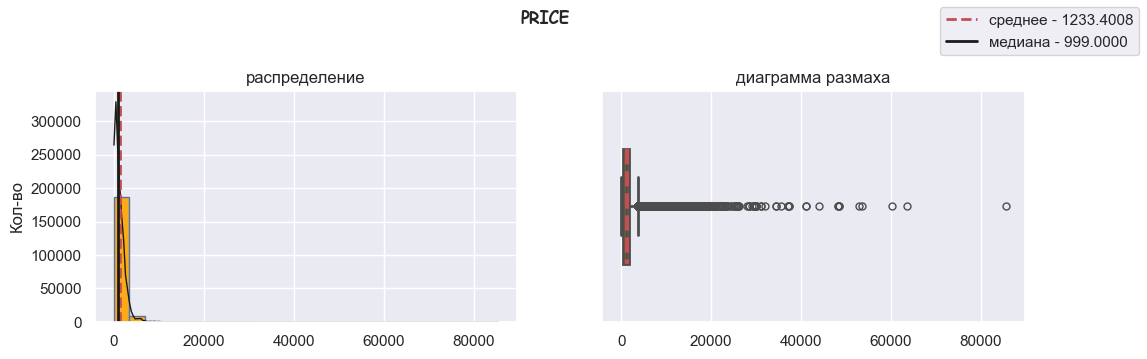

In [58]:
graph_num_plot(data_purchases, 'price')

Много выбросов из-за которых плохо видно распределение. Попробуем убрать выбросы и еще раз посмотрим на данные.

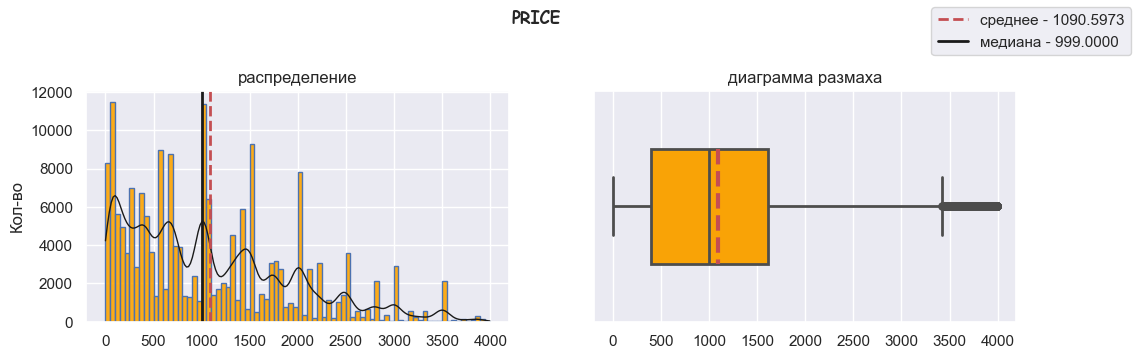

count   189_381.0000
mean      1_090.5973
std         857.8466
min           1.0000
25%         399.0000
50%         999.0000
75%       1_609.0000
max       3_993.0000
Name: price, dtype: float64

Количество отброшнных данных: 5984


In [60]:
data_purchases_ = data_purchases[data_purchases['price'] < data_purchases['price'].quantile(0.97)]
graph_num_plot(data_purchases_, 'price', 80)
display(data_purchases_['price'].describe())
print(f'Количество отброшнных данных: {data_purchases.shape[0] - data_purchases_.shape[0]}')

Большинство покупок лежит в интервале от 0 до 3500. Порядка 10к значение со стоимостью выше 3500. 

Построим еще распределение по стоимости.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


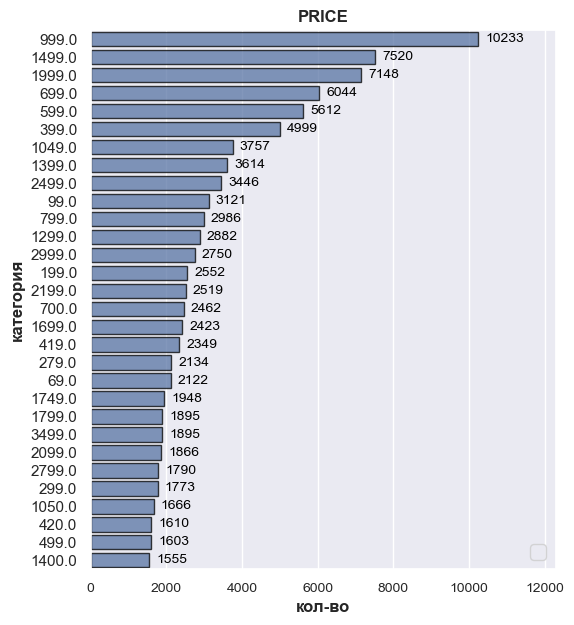

In [63]:
col='price'
bar_plot_func_comp(df=data_purchases, col=col, num_col=30)

Большинство покупок со стоимостью 999. Так же много покупок со стоимостью 1499 и 1999, но их меньше на 30%.

In [65]:
custom_dict_first = {k: v for v, k in enumerate(dff['cat_first'].value_counts().index)}

def root_last_ind(x):
    modes = pd.Series.value_counts(x).sort_index(key=lambda x: x.map(custom_dict_first)).index
    try:
        mode_ = modes[1]
    except:
        mode_ = 'none'
    return mode_
    
def root_first_ind(x):
    modes = pd.Series.value_counts(x).sort_index(key=lambda x: x.map(custom_dict_first)).index
    try:
        mode_ = modes[0]
    except:
        mode_ = 'none'
    return mode_


custom_dict_last = {k: v for v, k in enumerate(dff['cat_last'].value_counts().index)}

def sub_last_ind(x):
    modes = pd.Series.value_counts(x).sort_index(key=lambda x: x.map(custom_dict_last)).index
    try:
        mode_ = modes[1]
    except:
        mode_ = 'none'
    return mode_
    
def sub_first_ind(x):
    modes = pd.Series.value_counts(x).sort_index(key=lambda x: x.map(custom_dict_last)).index
    try:
        mode_ = modes[0]
    except:
        mode_ = 'none'
    return mode_

Начнем формировать наш обучающий/тестовый датасет. Так как мы будем предсказывать поведение пользователей, то в качестве индекса выделим уникальные идентификаторы пользователя и будем агрегировать остальные признаки вокруг него. 

Так так у пользователя может быть несколько любимых категорий (первых или последних), которые могут не отличаться кол-м, то будем выделять по две самые популярные категории для корневой категории (самой первой) и для самой последней. Если второй категории по предпочтению нет, то будем ее заполянть значением "None". Воспользуемся ранее созданными функциями cat_last_ind, cat_first_ind. Так же добавим пару признаков - кол-во уникальных категорий на пользователя.

In [68]:
df_g = dff.groupby(['client_id']).aggregate({'cat_first':[
                                                        lambda x: root_first_ind(x),
                                                        lambda x: root_last_ind(x),
                                                        pd.Series.nunique], 
                                             'cat_last':[
                                                         # 'count', 
                                                         pd.Series.nunique, 
                                                         lambda x: sub_first_ind(x),
                                                         lambda x: sub_last_ind(x),
                                                         lambda x: pd.Series.mode(x).shape[0]],
                                             })
df_g.columns = ['cat_first_pop_1', 'cat_first_pop_2', 'cat_first_nuniq', 'cat_last_nuniq', 'cat_last_pop_1', 'cat_last_pop_2', 'cat_last_nmods']
df_g.head()

,cat_first_pop_1,cat_first_pop_2,cat_first_nuniq,cat_last_nuniq,cat_last_pop_1,cat_last_pop_2,cat_last_nmods
client_id,,,,,,,
1515915625468060902,4,none,1,5,420,432,2
1515915625468061003,4,none,1,1,615,none,1
1515915625468061099,4,none,1,1,424,none,1
1515915625468061100,4,none,1,1,5717,none,1
1515915625468061170,4,2,2,3,420,432,1


Посмотрим на получившиеся значения после группировки, теперь у нас одна категория соответствуует одному пользователю.

In [70]:
dff.query('client_id == 1515915625487216007')['cat_first'].value_counts()
# sort_index(key=lambda x: x.map(custom_dict))

cat_first
5562    1
4       1
Name: count, dtype: int64

In [94]:
dff.query('client_id == 1515915625591285079')['cat_first'].value_counts()

cat_first
5562    1
2       1
Name: count, dtype: int64

In [95]:
dff.query('client_id == 1515915625504216799')['cat_first'].value_counts()

cat_first
4    4
2    4
Name: count, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


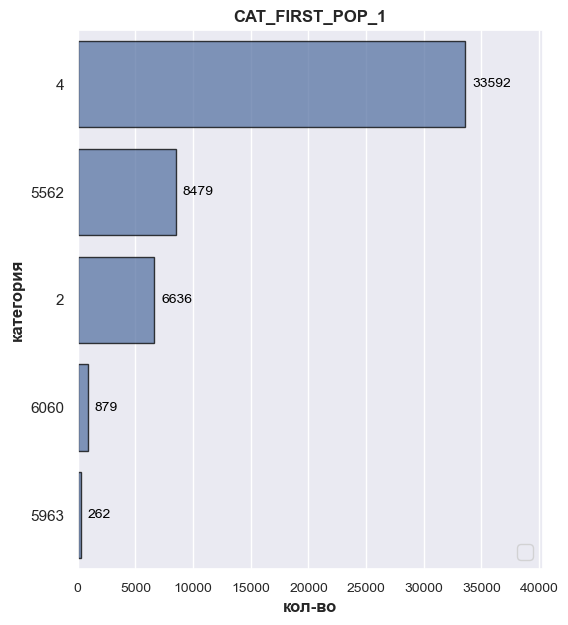

In [96]:
col='cat_first_pop_1'
bar_plot_func_comp(df=df_g, col=col, num_col=30)

Больше всего категория относящихся к "4", на втором месте по популярности идут категория "5562" и "2"

Посмотрим на распределение второй по значимости категории.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


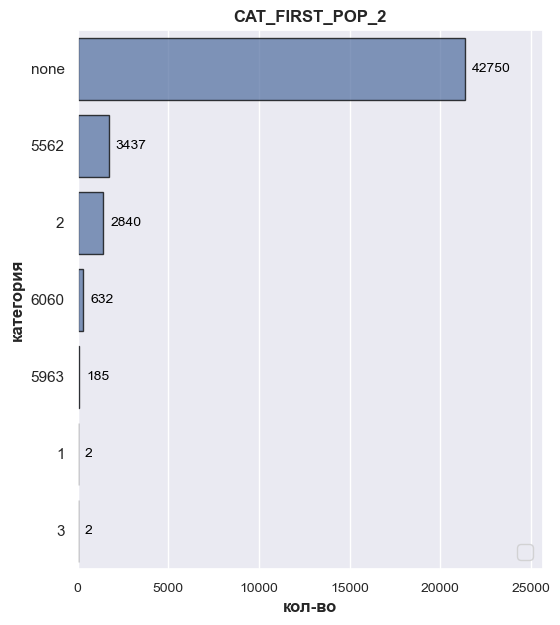

In [99]:
col='cat_first_pop_2'
bar_plot_func_comp(df=df_g, col=col, num_col=30)

У большинства пользователей нет второй любимой категории. Для других порядок следования популярных "4", "5562" и "2", схожие категории как и у первой.

Посмотрим на распределение по последней категории.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


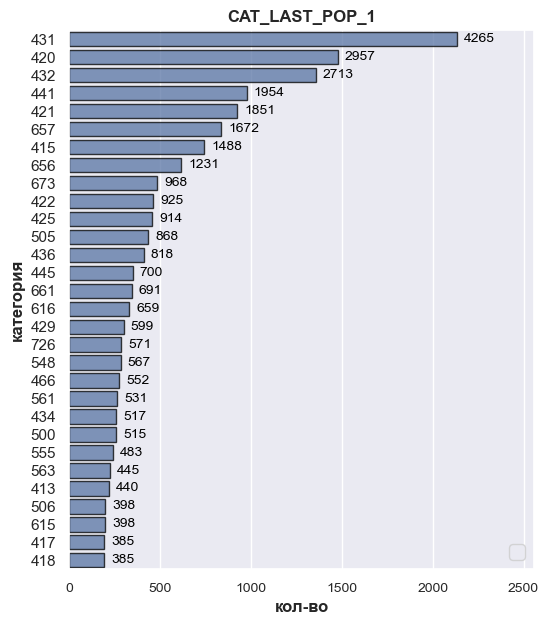

In [101]:
col='cat_last_pop_1'
bar_plot_func_comp(df=df_g, col=col, num_col=30)

Самая большая категория "431", после, по популярности, идут категории "420" и "432"

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


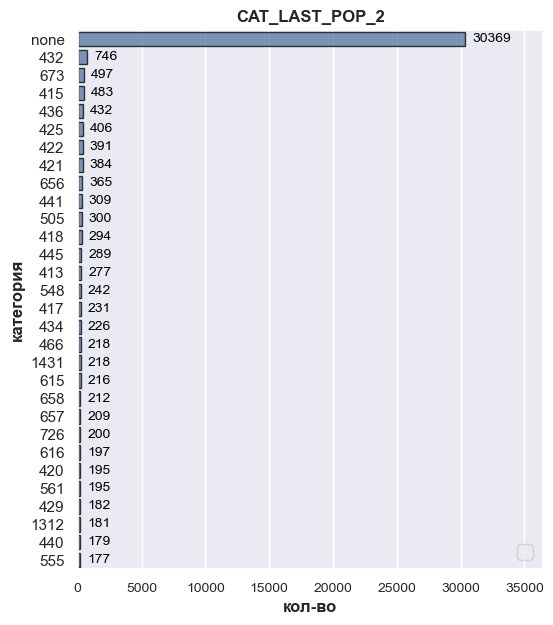

In [103]:
col='cat_last_pop_2'
bar_plot_func_comp(df=df_g, col=col, num_col=30)

У большинства пользователей нет второй любимой категории. Для других порядок следования популярных "432", "673" и "415".

Сделаем вторую часть нашей итоговой таблицы, на этот раз будем работать с признаками "price", "quantity". Объедимим пользователей с учетом данных признаков.

In [106]:
df__ = data_purchases.groupby(['client_id', 'category_ids', 'date'], as_index=False).aggregate({'price':'sum', 'quantity':'sum'})

In [107]:
df__.columns

Index(['client_id', 'category_ids', 'date', 'price', 'quantity'], dtype='object')

In [108]:
df__

,client_id,category_ids,date,price,quantity
0,1515915625468060902,"['4', '27', '176', '458']",2022-05-27,398.0000,2
1,1515915625468060902,"['4', '27', '1828', '1599']",2022-05-27,1_299.0000,1
2,1515915625468060902,"['4', '28', '244', '432']",2022-05-27,999.0000,1
3,1515915625468060902,"['4', '28', '260', '420']",2022-05-27,3_998.0000,2
4,1515915625468060902,"['4', '28', '290', '422']",2022-05-27,299.0000,1
...,...,...,...,...,...
93588,1515915626010261344,"['2', '18', '212', '726']",2024-02-16,8_994.0000,6
93589,1515915626010266132,"['4', '27', '278', '470']",2024-02-14,1_818.0000,2
93590,1515915626010439406,"['4', '27', '233', '462']",2024-02-16,198.0000,2
93591,1515915626010443527,"['2', '18', '274', '446']",2024-02-16,1_999.0000,1


В исходной таблице объединили стоимость по всем однотипным заказам в один, получили количестов позиций в заказе.

Сагригируем и получим общее кол-во заказов, и получим следующие новые признаки, 
- общая сумма покупок, price, чем больше сумма трат, тем с большей вероятностью он купит в дальнейшем. Но тут стоит учитывать, что это могла быть одна одна дорогостояшая покупка или срочная.
- медианна значение, price_median, мелики покупки будут совершаться чаще. 
- количество покупок в одном чеке, quantity  
- количество заказов, orders, чем чаще человек покупает тем чаще он будет покупать в дальнейшем, если, конечно, не будет негативных случаев.

In [237]:
dff = df__.groupby(['client_id']).aggregate({'price':['sum', 'mean'], 'quantity':['sum', 'count']})
dff.columns = ['price', 'price_median','quantity', 'orders']
dff

,price,price_median,quantity,orders
client_id,,,,
1515915625468060902,6_993.0000,1_398.6000,7,5
1515915625468061003,16_235.0000,16_235.0000,7,1
1515915625468061099,299.0000,299.0000,1,1
1515915625468061100,2_098.0000,2_098.0000,2,1
1515915625468061170,33_587.0000,11_195.6667,17,3
...,...,...,...,...
1515915626010261344,8_994.0000,8_994.0000,6,1
1515915626010266132,1_818.0000,1_818.0000,2,1
1515915626010439406,198.0000,198.0000,2,1


Объединим с категориальными признаками категорий заказов и поличим нашу таблицу для обучения

In [240]:
dataframe = pd.concat([df_g, dff], axis=1)
dataframe

,cat_first_pop_1,cat_first_pop_2,cat_first_nuniq,cat_last_nuniq,cat_last_pop_1,cat_last_pop_2,cat_last_nmods,price,price_median,quantity,orders
client_id,,,,,,,,,,,
1515915625468060902,4,none,1,5,420,432,2,6_993.0000,1_398.6000,7,5
1515915625468061003,4,none,1,1,615,none,1,16_235.0000,16_235.0000,7,1
1515915625468061099,4,none,1,1,424,none,1,299.0000,299.0000,1,1
1515915625468061100,4,none,1,1,5717,none,1,2_098.0000,2_098.0000,2,1
1515915625468061170,4,2,2,3,420,432,1,33_587.0000,11_195.6667,17,3
...,...,...,...,...,...,...,...,...,...,...,...
1515915626010261344,2,none,1,1,726,none,1,8_994.0000,8_994.0000,6,1
1515915626010266132,4,none,1,1,470,none,1,1_818.0000,1_818.0000,2,1
1515915626010439406,4,none,1,1,462,none,1,198.0000,198.0000,2,1


В качестве признака можно было бы выделит сезонность, посмотрим как выделяются. Для этого возьмем датасет df__, в котором были объединены разбитые заказы в один.

In [243]:
data_purchases_ = df__.copy()
data_purchases_['date_M'] = pd.to_datetime(data_purchases_['date']).dt.to_period('M')
data_purchases_['date_Y'] = pd.to_datetime(data_purchases_['date']).dt.to_period('Y')
data_purchases_['date'] = pd.to_datetime(data_purchases_['date'])
# data_purchases_ = data_purchases_.date.value_counts()
# data_purchases_ = data_purchases_.sort_index(ascending=False)

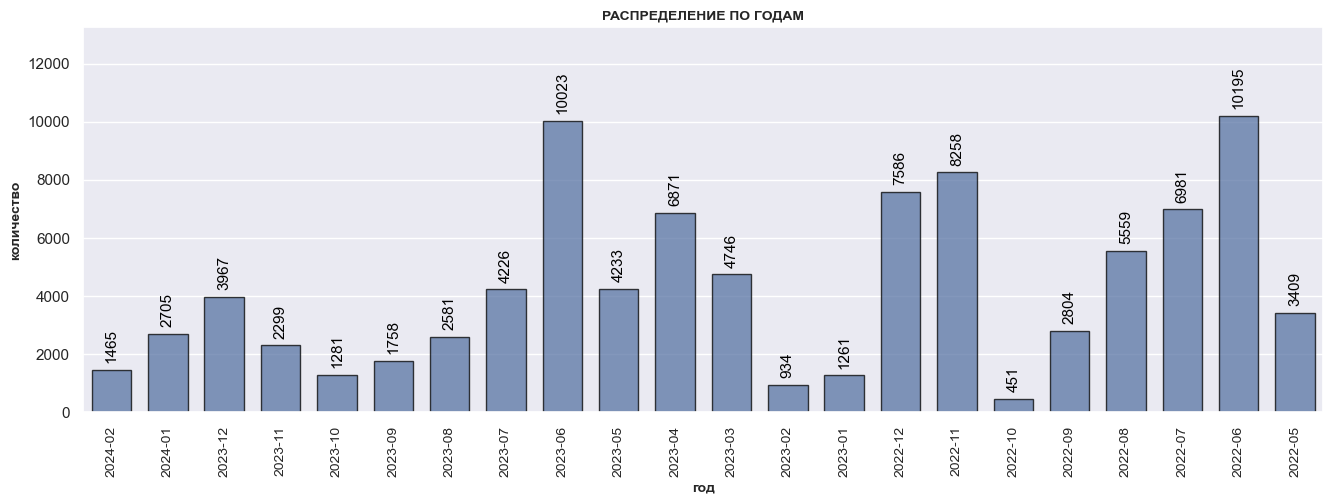

In [245]:
data_purchases_stat = data_purchases_['date_M'].value_counts()
data_purchases_stat = data_purchases_stat.sort_index(ascending=False)
bar_plor_func(data_purchases_stat, x_name = 'год', y_name = 'количество', title_name='Распределение по годам', num_col=100)

Если смотреть сезонность, то больше всего покупок июне, люди оттыхают или готовяться к отдыху. Так же есть увеличение в ноябре и декабре, но в последнем году, заказов в данных месяцах 2-3 раза меньше.

Попробуем как-то объединить по месяцам и посмотрим общую картину

In [249]:
data_purchases_['date_MM'] = pd.to_datetime(data_purchases_['date']).dt.month

In [251]:
d = data_purchases_.groupby(['date_MM']).count()['date'].sort_index(ascending=False)
d= d/ d.sum()

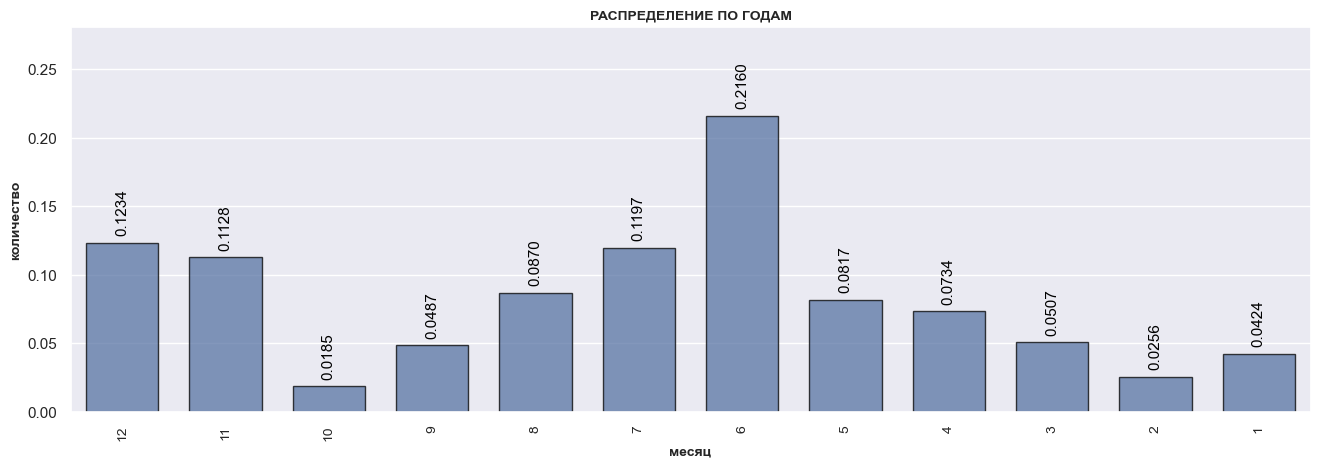

In [253]:
bar_plor_func(d, x_name = 'месяц', y_name = 'количество', title_name='Распределение по годам', num_col=100, rond=4)

Посмотрим как распределены заказы одного и того же клиента по месяцам

In [256]:
mm = data_purchases_.groupby(['client_id', 'date_M'], as_index=False)[['quantity']].count()
mm.head(10)

,client_id,date_M,quantity
0,1515915625468060902,2022-05,5
1,1515915625468061003,2023-01,1
2,1515915625468061099,2022-05,1
3,1515915625468061100,2024-02,1
4,1515915625468061170,2023-03,2
5,1515915625468061170,2023-06,1
6,1515915625468061514,2022-07,1
7,1515915625468061877,2022-08,1
8,1515915625468061975,2022-07,1
9,1515915625468061994,2022-11,1


Видно, что одни клиенты делали покупки в течении одного месяца, а другие в разные. Из этого можно сделать признак. 

In [259]:
mm = data_purchases_.groupby(['client_id', 'date_M'], as_index=False)[['quantity']].count()
mm_ = mm['client_id'].value_counts()
mm_ 

client_id
1515915625500232103    10
1515915625853312319    10
1515915625490334876     9
1515915625468159950     9
1515915625559408913     9
                       ..
1515915625491942117     1
1515915625491947402     1
1515915625491958564     1
1515915625491985399     1
1515915626010443624     1
Name: count, Length: 49848, dtype: int64

Посмотрим количество покупак по пользователям

In [262]:
f"Количество покупок в один месяц: {mm_[mm_==1].count()/mm_.shape[0]}"

'Количество покупок в один месяц: 0.8934159845931632'

Большинство пользователей, почти 90%, совершили покупки в один месяц. Сделаем столбец признаков

In [265]:
dataframe['num_mounth'] = [i if i==0 else 1 for i in (mm.groupby('client_id')[['date_M']].count().values[:,0]-1)]
dataframe

,cat_first_pop_1,cat_first_pop_2,cat_first_nuniq,cat_last_nuniq,cat_last_pop_1,cat_last_pop_2,cat_last_nmods,price,price_median,quantity,orders,num_mounth
client_id,,,,,,,,,,,,
1515915625468060902,4,none,1,5,420,432,2,6_993.0000,1_398.6000,7,5,0
1515915625468061003,4,none,1,1,615,none,1,16_235.0000,16_235.0000,7,1,0
1515915625468061099,4,none,1,1,424,none,1,299.0000,299.0000,1,1,0
1515915625468061100,4,none,1,1,5717,none,1,2_098.0000,2_098.0000,2,1,0
1515915625468061170,4,2,2,3,420,432,1,33_587.0000,11_195.6667,17,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1515915626010261344,2,none,1,1,726,none,1,8_994.0000,8_994.0000,6,1,0
1515915626010266132,4,none,1,1,470,none,1,1_818.0000,1_818.0000,2,1,0
1515915626010439406,4,none,1,1,462,none,1,198.0000,198.0000,2,1,0


Посмотрим распределене по годам. 

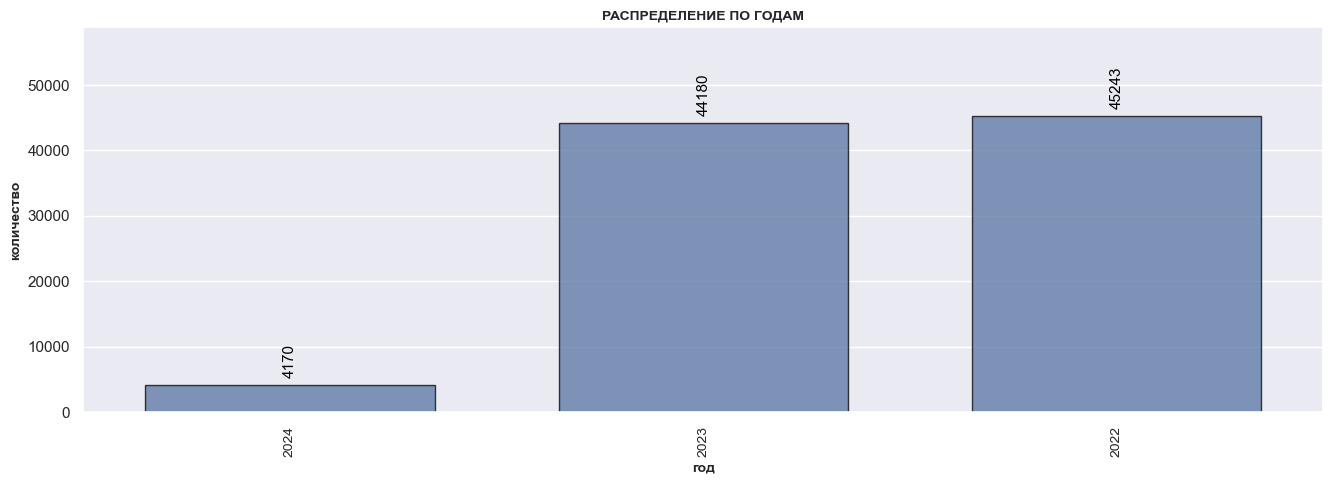

In [268]:
data_purchases_stat = data_purchases_['date_Y'].value_counts()
data_purchases_stat = data_purchases_stat.sort_index(ascending=False)
bar_plor_func(data_purchases_stat, x_name = 'год', y_name = 'количество', title_name='Распределение по годам', num_col=10)

Продажи в 2023 сопоставимы с продажами в 2022, хотя данные по прадажам за 2022 неполные, там не хватает 4х месяцев. Данные за 2024 представлены только двумя месяцами и нет смысла на основе данных цифр делать какие-то заключения.

In [271]:
date_max = data_purchases_['date'].max()
date_min = data_purchases_['date'].min()
date_max, date_min

(Timestamp('2024-02-16 00:00:00'), Timestamp('2022-05-16 00:00:00'))

In [273]:
df__

,client_id,category_ids,date,price,quantity
0,1515915625468060902,"['4', '27', '176', '458']",2022-05-27,398.0000,2
1,1515915625468060902,"['4', '27', '1828', '1599']",2022-05-27,1_299.0000,1
2,1515915625468060902,"['4', '28', '244', '432']",2022-05-27,999.0000,1
3,1515915625468060902,"['4', '28', '260', '420']",2022-05-27,3_998.0000,2
4,1515915625468060902,"['4', '28', '290', '422']",2022-05-27,299.0000,1
...,...,...,...,...,...
93588,1515915626010261344,"['2', '18', '212', '726']",2024-02-16,8_994.0000,6
93589,1515915626010266132,"['4', '27', '278', '470']",2024-02-14,1_818.0000,2
93590,1515915626010439406,"['4', '27', '233', '462']",2024-02-16,198.0000,2
93591,1515915626010443527,"['2', '18', '274', '446']",2024-02-16,1_999.0000,1


Учитывая что у нас есть временной столбец, то мы можем посмотреть как давно пользователь делал покупки и определить интервал покупок из которого потом определить частоту покупок за данный интервал

In [276]:
data_purchases_date = data_purchases_.groupby(['client_id']).agg({'date': 
                                            [
                                            lambda x: (date_max - x.max()).days,
                                            lambda x: (x.max() - x.min()).days,
                                            ]})
data_purchases_date.columns = ['last_purch', 'delta']
data_purchases_date

,last_purch,delta
client_id,,
1515915625468060902,630,0
1515915625468061003,408,0
1515915625468061099,640,0
1515915625468061100,6,0
1515915625468061170,244,83
...,...,...
1515915626010261344,0,0
1515915626010266132,2,0
1515915626010439406,0,0


Объединим с основным датафреймом

In [278]:
dataframe_ = pd.concat([dataframe, data_purchases_date], axis=1)
dataframe_

,cat_first_pop_1,cat_first_pop_2,cat_first_nuniq,cat_last_nuniq,cat_last_pop_1,cat_last_pop_2,cat_last_nmods,price,price_median,quantity,orders,num_mounth,last_purch,delta
client_id,,,,,,,,,,,,,,
1515915625468060902,4,none,1,5,420,432,2,6_993.0000,1_398.6000,7,5,0,630,0
1515915625468061003,4,none,1,1,615,none,1,16_235.0000,16_235.0000,7,1,0,408,0
1515915625468061099,4,none,1,1,424,none,1,299.0000,299.0000,1,1,0,640,0
1515915625468061100,4,none,1,1,5717,none,1,2_098.0000,2_098.0000,2,1,0,6,0
1515915625468061170,4,2,2,3,420,432,1,33_587.0000,11_195.6667,17,3,1,244,83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515915626010261344,2,none,1,1,726,none,1,8_994.0000,8_994.0000,6,1,0,0,0
1515915626010266132,4,none,1,1,470,none,1,1_818.0000,1_818.0000,2,1,0,2,0
1515915626010439406,4,none,1,1,462,none,1,198.0000,198.0000,2,1,0,0,0


In [279]:
def freq_delt(df):
    if df['delta'] != 0:
        return df['orders'] / df['delta'] 
    else:
        return 0

Посчитаем частоту покупок

In [281]:
dataframe_['freq'] = dataframe_.apply(freq_delt, axis=1)

In [282]:
dataframe_

,cat_first_pop_1,cat_first_pop_2,cat_first_nuniq,cat_last_nuniq,cat_last_pop_1,cat_last_pop_2,cat_last_nmods,price,price_median,quantity,orders,num_mounth,last_purch,delta,freq
client_id,,,,,,,,,,,,,,,
1515915625468060902,4,none,1,5,420,432,2,6_993.0000,1_398.6000,7,5,0,630,0,0.0000
1515915625468061003,4,none,1,1,615,none,1,16_235.0000,16_235.0000,7,1,0,408,0,0.0000
1515915625468061099,4,none,1,1,424,none,1,299.0000,299.0000,1,1,0,640,0,0.0000
1515915625468061100,4,none,1,1,5717,none,1,2_098.0000,2_098.0000,2,1,0,6,0,0.0000
1515915625468061170,4,2,2,3,420,432,1,33_587.0000,11_195.6667,17,3,1,244,83,0.0361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515915626010261344,2,none,1,1,726,none,1,8_994.0000,8_994.0000,6,1,0,0,0,0.0000
1515915626010266132,4,none,1,1,470,none,1,1_818.0000,1_818.0000,2,1,0,2,0,0.0000
1515915626010439406,4,none,1,1,462,none,1,198.0000,198.0000,2,1,0,0,0,0.0000


С этим датафреймом мы немного разобрались пробежимся быстро по датафрейму data_messages

In [284]:
data_messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


Посмотрим информацию по датафрейму 

In [286]:
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


Есть признак date, по нему можно попробовоть создать признак.

Посмотрим на признак event

In [289]:
data_messages.event.value_counts()

event
send           9058196
open           3085820
click           496339
purchase         64679
hard_bounce      19903
soft_bounce      10583
unsubscribe       2841
hbq_spam           823
complain           528
subscribe           85
close                1
Name: count, dtype: int64

Из датафрейма можно попробовать извлечь признак число кликов, число открытий, тип канала и остальные. При преобразовании пустые значения заменим нулями.

In [291]:
data_messages_ = data_messages.groupby(['client_id', 'event'])[['event']].count().unstack()['event'].fillna(0)
data_messages_

event,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
client_id,,,,,,,,,,,
1515915625468060902,10.0000,0.0000,0.0000,0.0000,0.0000,35.0000,5.0000,126.0000,0.0000,0.0000,1.0000
1515915625468061003,6.0000,0.0000,0.0000,0.0000,0.0000,5.0000,1.0000,154.0000,0.0000,0.0000,0.0000
1515915625468061099,8.0000,0.0000,0.0000,2.0000,0.0000,51.0000,0.0000,215.0000,0.0000,0.0000,0.0000
1515915625468061100,1.0000,0.0000,0.0000,1.0000,0.0000,163.0000,1.0000,267.0000,1.0000,0.0000,0.0000
1515915625468061170,16.0000,0.0000,0.0000,0.0000,0.0000,31.0000,3.0000,243.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
1515915626010183608,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,2.0000,0.0000,0.0000,0.0000
1515915626010221592,3.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,2.0000,0.0000,0.0000,0.0000
1515915626010234726,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000


Объединим с исходным датафреймом

In [293]:
dataframe_ = pd.merge(dataframe_,data_messages_, how='left',on='client_id')
dataframe_

,cat_first_pop_1,cat_first_pop_2,cat_first_nuniq,cat_last_nuniq,cat_last_pop_1,cat_last_pop_2,cat_last_nmods,price,price_median,quantity,...,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
client_id,,,,,,,,,,,,,,,,,,,,,
1515915625468060902,4,none,1,5,420,432,2,6_993.0000,1_398.6000,7,...,0.0000,0.0000,0.0000,0.0000,35.0000,5.0000,126.0000,0.0000,0.0000,1.0000
1515915625468061003,4,none,1,1,615,none,1,16_235.0000,16_235.0000,7,...,0.0000,0.0000,0.0000,0.0000,5.0000,1.0000,154.0000,0.0000,0.0000,0.0000
1515915625468061099,4,none,1,1,424,none,1,299.0000,299.0000,1,...,0.0000,0.0000,2.0000,0.0000,51.0000,0.0000,215.0000,0.0000,0.0000,0.0000
1515915625468061100,4,none,1,1,5717,none,1,2_098.0000,2_098.0000,2,...,0.0000,0.0000,1.0000,0.0000,163.0000,1.0000,267.0000,1.0000,0.0000,0.0000
1515915625468061170,4,2,2,3,420,432,1,33_587.0000,11_195.6667,17,...,0.0000,0.0000,0.0000,0.0000,31.0000,3.0000,243.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515915626010261344,2,none,1,1,726,none,1,8_994.0000,8_994.0000,6,...,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
1515915626010266132,4,none,1,1,470,none,1,1_818.0000,1_818.0000,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1515915626010439406,4,none,1,1,462,none,1,198.0000,198.0000,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Так как появились пустые строки забьем их нулями

In [295]:
dataframe_ = dataframe_.fillna(0)
dataframe_

,cat_first_pop_1,cat_first_pop_2,cat_first_nuniq,cat_last_nuniq,cat_last_pop_1,cat_last_pop_2,cat_last_nmods,price,price_median,quantity,...,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
client_id,,,,,,,,,,,,,,,,,,,,,
1515915625468060902,4,none,1,5,420,432,2,6_993.0000,1_398.6000,7,...,0.0000,0.0000,0.0000,0.0000,35.0000,5.0000,126.0000,0.0000,0.0000,1.0000
1515915625468061003,4,none,1,1,615,none,1,16_235.0000,16_235.0000,7,...,0.0000,0.0000,0.0000,0.0000,5.0000,1.0000,154.0000,0.0000,0.0000,0.0000
1515915625468061099,4,none,1,1,424,none,1,299.0000,299.0000,1,...,0.0000,0.0000,2.0000,0.0000,51.0000,0.0000,215.0000,0.0000,0.0000,0.0000
1515915625468061100,4,none,1,1,5717,none,1,2_098.0000,2_098.0000,2,...,0.0000,0.0000,1.0000,0.0000,163.0000,1.0000,267.0000,1.0000,0.0000,0.0000
1515915625468061170,4,2,2,3,420,432,1,33_587.0000,11_195.6667,17,...,0.0000,0.0000,0.0000,0.0000,31.0000,3.0000,243.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515915626010261344,2,none,1,1,726,none,1,8_994.0000,8_994.0000,6,...,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
1515915626010266132,4,none,1,1,470,none,1,1_818.0000,1_818.0000,2,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1515915626010439406,4,none,1,1,462,none,1,198.0000,198.0000,2,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [296]:
dataframe_ = pd.merge(dataframe_, data_target, how='left',on='client_id')
dataframe_

,client_id,cat_first_pop_1,cat_first_pop_2,cat_first_nuniq,cat_last_nuniq,cat_last_pop_1,cat_last_pop_2,cat_last_nmods,price,price_median,...,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe,target
0,1515915625468060902,4,none,1,5,420,432,2,6_993.0000,1_398.6000,...,0.0000,0.0000,0.0000,35.0000,5.0000,126.0000,0.0000,0.0000,1.0000,0
1,1515915625468061003,4,none,1,1,615,none,1,16_235.0000,16_235.0000,...,0.0000,0.0000,0.0000,5.0000,1.0000,154.0000,0.0000,0.0000,0.0000,1
2,1515915625468061099,4,none,1,1,424,none,1,299.0000,299.0000,...,0.0000,2.0000,0.0000,51.0000,0.0000,215.0000,0.0000,0.0000,0.0000,0
3,1515915625468061100,4,none,1,1,5717,none,1,2_098.0000,2_098.0000,...,0.0000,1.0000,0.0000,163.0000,1.0000,267.0000,1.0000,0.0000,0.0000,0
4,1515915625468061170,4,2,2,3,420,432,1,33_587.0000,11_195.6667,...,0.0000,0.0000,0.0000,31.0000,3.0000,243.0000,0.0000,0.0000,0.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49843,1515915626010261344,2,none,1,1,726,none,1,8_994.0000,8_994.0000,...,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0
49844,1515915626010266132,4,none,1,1,470,none,1,1_818.0000,1_818.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
49845,1515915626010439406,4,none,1,1,462,none,1,198.0000,198.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
49846,1515915626010443527,2,none,1,1,446,none,1,1_999.0000,1_999.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0


### 2. Проверка на мультиколлинеарность.

Так как у нас получилось много признаков и мы впоследствии будем перебирать гиперпараметры для нескольких моделей, 
рассчитаем коэффициент связи между признаками и избавимся от парочки. Для этого воспользуемся библиотекой phik. При расчете выберем часть датасета, что бы быстрее посчиталось.

Изучим взаимосвязь между признаками. Рассчитаем коэффициенты корреляции между всеми признаками.
Построим диаграммы рассеяния scatterplot для целевого признака и всех количественных признаков с учётом значения категориальных признаков.

In [308]:
dataframe_corr = dataframe_.drop(['client_id'], axis=1)

interval columns not set, guessing: ['cat_first_nuniq', 'cat_last_nuniq', 'cat_last_nmods', 'price', 'price_median', 'quantity', 'orders', 'num_mounth', 'last_purch', 'delta', 'freq', 'click', 'close', 'complain', 'hard_bounce', 'hbq_spam', 'open', 'purchase', 'send', 'soft_bounce', 'subscribe', 'unsubscribe', 'target']


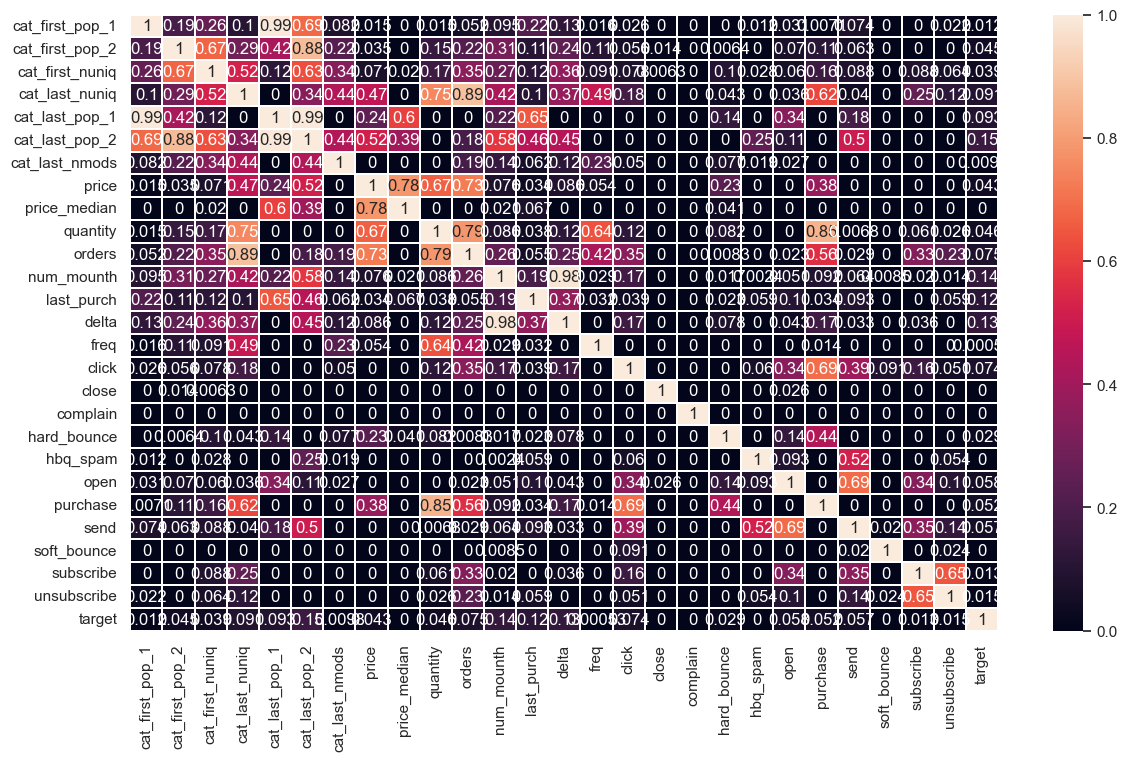

In [309]:
plt.figure(figsize=(14, 8))
ax=sns.heatmap(dataframe_corr.phik_matrix(), 
            annot = True, 
            vmin=0, 
            vmax=1, 
            cmap= 'rocket', 
            linewidths=0.1, 
            linecolor='white', 
            cbar_kws= {'orientation': 'vertical'});

Видны следующие закономерности:
Между некоторыми признаками наблюдается высокая связь. Например "cat_last_pop_2" сильно связан с признаками "cat_last_pop_2", "cat_first_pop_2". Один из признаков можно дробнуть. Тоже относиться к остальным признакам с сильной связью.
Отдельно выведем столбец только для целевого признака и посмотрим с кем у нее сильная связь.

interval columns not set, guessing: ['cat_first_nuniq', 'cat_last_nuniq', 'cat_last_nmods', 'price', 'price_median', 'quantity', 'orders', 'num_mounth', 'last_purch', 'delta', 'freq', 'click', 'close', 'complain', 'hard_bounce', 'hbq_spam', 'open', 'purchase', 'send', 'soft_bounce', 'subscribe', 'unsubscribe', 'target']


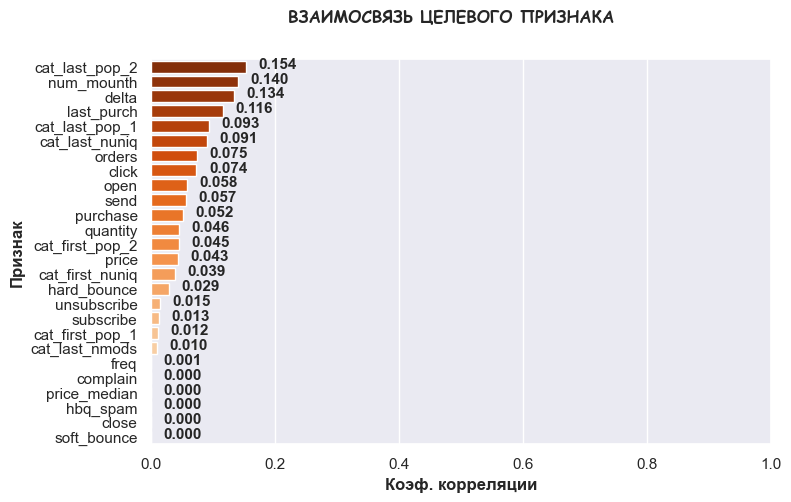

In [312]:
df_train_phik = dataframe_corr.phik_matrix()['target'].sort_values(ascending=False)[1:]
corr_plor_func(df_train_phik, (0,1), 'Взаимосвязь целевого признака')

Избавимся от столбцов у которых нулевая связь с целевым признаком.

In [314]:
# dataframe_corr = dataframe_corr.drop(['close', 'hard_bounce', 'hbq_spam', 
#                                       'soft_bounce', 'complain', 'cat_last_nmods',
#                                       'freq', 'price_median', 'cat_last_pop_2', 
#                                       'cat_first_pop_2', 'subscribe', 'unsubscribe'
#                                      ], axis=1)

In [315]:
dataframe_corr = dataframe_corr.drop(['close', 'hard_bounce', 'hbq_spam', 
                                      'soft_bounce', 'complain', 'cat_last_nmods',
                                       'cat_last_pop_2', 
                                      'cat_first_pop_2', 'subscribe', 'unsubscribe'
                                     ], axis=1)

interval columns not set, guessing: ['cat_first_nuniq', 'cat_last_nuniq', 'price', 'price_median', 'quantity', 'orders', 'num_mounth', 'last_purch', 'delta', 'freq', 'click', 'open', 'purchase', 'send', 'target']


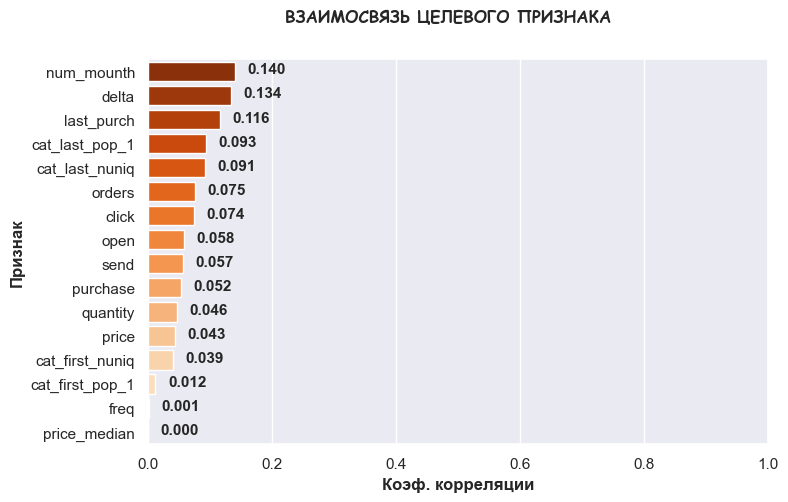

In [318]:
df_train_phik = dataframe_corr.phik_matrix()['target'].sort_values(ascending=False)[1:]
corr_plor_func(df_train_phik, (0,1), 'Взаимосвязь целевого признака')

По полученной таблице видна зависимость целевого признак. Связь со всеми признаками слабая, не более 0.17.
Сильнее всего связь со след. признаками: cat_last_pop_2, num_mounth, delta, last_purch. Для остальных признаков связь менее 0.01.

При обучении модели можно попробовать избавиться от некоторых признаков, которые сильно взаимосвязаны или для которых взаимосвязь с целевым признаком оказалась миниальной.
К таким призначам относятся 'name','state_code', 'country_code', 'region', 'city', 'category_list', 'founded_at', 'closed_at'

### 3. Подготовка данных

Подготовку признаков выполним в пайплайне, дополнив пайплайн шага предобработки.

<a id='section_2_5_1'></a>

#### 3.1. Создание пайплайна

Создадим пайплайн для обработки данных. При кодировании будем учитывать особенности признаков и моделей.

In [330]:
dataframe_corr.columns

Index(['cat_first_pop_1', 'cat_first_nuniq', 'cat_last_nuniq',
       'cat_last_pop_1', 'price', 'price_median', 'quantity', 'orders',
       'num_mounth', 'last_purch', 'delta', 'freq', 'click', 'open',
       'purchase', 'send', 'target'],
      dtype='object')

In [510]:
# ohe_columns = [
#     'cat_first_pop_1', 'cat_first_pop_2', 'cat_last_pop_1', 'cat_last_pop_2'
# ]

ohe_columns = [
    'cat_first_pop_1', 'cat_last_pop_1',
]

# num_columns = ['cat_first_nuniq', 'cat_last_nuniq','price', 'quantity', 
#                'orders', 'num_mounth', 'last_purch', 'delta', 'click', 
#                'open', 'purchase', 'send', 'price_median']

num_columns = ['cat_first_nuniq','cat_last_nuniq', 'price', 'quantity',
              'orders', 'num_mounth','last_purch', 'delta', 'click',
            'open', 'purchase', 'send','freq', 'price_median'
            ]


ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
            # OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
)



data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)


pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

Зададим модели с учетом гиперпараметров. Будем использовать пять моделей KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression, Ridge и SVC.

In [607]:
param_distributions_class = [

     # словарь для модели KNeighborsClassifier() 
    {
        # название модели
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },

    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 12),
        'models__max_features': range(4, 10),
        'models__min_samples_split': range(1, 4),
        'models__min_samples_leaf': range(1, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # # словарь для модели SVC()
    #  {
    #     'models': [SVC(random_state=RANDOM_STATE)],
    #     'models__C':np.arange(1,10,1),
    #     'models__degree':np.arange(1,4),
    #     'models__coef0':np.arange(0.0001,0.001,0.05),
    #     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    
    # },
    
    #     {
    #     'models': [SVC(kernel='poly', random_state=RANDOM_STATE)],
    #     'models__C':np.arange(1,10,1),
    #     'models__degree':np.arange(1,4),
    #     'models__coef0':np.arange(0.0001,0.001,0.05),
    #     # 'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    
    # },
    
    # {
    #     'models': [SVC(kernel='sigmoid', random_state=RANDOM_STATE)],
    #     'models__C':np.arange(1,10,1),
    #     'models__degree':np.arange(1,4),
    #     'models__coef0':np.arange(0.0001,0.001,0.05),
    #     # 'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    
    # },  
    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели Ridge
    {
        'models': [RidgeClassifier(random_state=RANDOM_STATE)],
        "models__alpha": [1, 10, 100, 450, 500, 550],
        "models__fit_intercept": [True, False],
        # "models__solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
] 

Выбор лучшей модели будем делать на основе метрики ROC_AUC.

<a id='section_2_5_2'></a>

#### 3.2. Промежуточный вывод

Создан пайплайн предобработки данных. Заданы пять моделей KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression, Ridge и SVC с учетом перебора гиперпараметров. В качестве метрики лучшей модели будем использовать ROC_AUC.

<a id='section_2_6'></a>

### 4. Создание моделей

Обучим пять моделей: KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression, Ridge и SVC. Выберем лучшую модель по результатам. Отдельно обучим модель градиентного бустинга.

<a id='section_2_6_1'></a>

#### 4.1. Обучение моделей

Разделим нашу выборку на тестовую и тренировочную. Обязательно укажем стратификацию по целевой переменной.

In [526]:
X_train, X_test, y_train, y_test = train_test_split(
    dataframe_corr.drop(
        [
            'target',
        ], 
        axis=1
    ),
    dataframe_corr['target'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = dataframe_corr['target']
)

Создадим класс для автоматизированного поиска гиперпараметров. Перебирать гиперпараметры будем с помощью GridSearchCV. В качетсве метрики будем использовать ROC_AUC.

In [609]:
grid_search_class = GridSearchCV(
    pipe_final, 
    param_grid=param_distributions_class,
    cv=5,
    scoring='roc_auc', 
    n_jobs=-1
)

In [611]:
%%time
grid_search_class.fit(X_train, y_train);

CPU times: total: 1min 31s
Wall time: 10min 50s


Считалось порядка 1:30 с простой SVC (считает долго, качество небольшое - убрал в дальнейшем), посмотрим на результат. Без нее расчет 11 мин.

In [615]:
pd.options.display.float_format = '{:_.10f}'.format
result = pd.DataFrame(grid_search_class.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')[:5])

,rank_test_score,param_models,mean_test_score,params
804,1,RidgeClassifier(random_state=42),0.7320000811,"{'models': RidgeClassifier(random_state=42), '..."
810,2,RidgeClassifier(random_state=42),0.7319621224,"{'models': RidgeClassifier(random_state=42), '..."
808,3,RidgeClassifier(random_state=42),0.7319454654,"{'models': RidgeClassifier(random_state=42), '..."
802,4,RidgeClassifier(random_state=42),0.7319422039,"{'models': RidgeClassifier(random_state=42), '..."
816,5,RidgeClassifier(random_state=42),0.7319312511,"{'models': RidgeClassifier(random_state=42), '..."


In [617]:
print('Лучшая модель и её параметры:\n\n', grid_search_class.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search_class.best_score_)

# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_test_pred = grid_search_class.predict(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['cat_first_pop_1',
                                                   'cat_last_pop_1']),
                                                 ('num', 'passthrough',
                           

In [619]:
cross_val_score(grid_search_class.best_estimator_, X_test, y_test, cv=4, scoring='roc_auc').mean()

0.7234989240633223

Был построен пайплайн и обучена модель на итоговом датасете. При выборе модели были обучены пять модели: KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression, Ridge и SVC. В качестве метрики была выбрана "roc_auc" так как она устойчива к неравновесным выборкам. SVC расчет с разыми ядрами и перебором гиперпараметров показал результат 0,57 на тестовой и похожее значение на тренировочной выборке. Время расчета получилось 3 часа. Поэтому в оконтательном варианте не стал оставлять даже простую модель.

#### 4.2. Обучим модель градиентного бустинга

Обучим модель градиентного бустинга и посмотрим на ее результат. В качестве модели возьмем LGBMClassifier, так как она быстро учиться.

In [624]:
cat_col = X_train.select_dtypes(include='object').columns.to_list()
for col in cat_col:
    X_train[col] = X_train[col].astype('category')

In [626]:
lgbm = LGBMClassifier(metric='auc', random_state=RANDOM_STATE, class_weight={0:50, 1:0.02})

In [628]:
cross_val_score(lgbm, X_train, y_train, cv=5, scoring='roc_auc').mean()

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 654, number of negative: 33242
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2461
[LightGBM] [Info] Number of data points in the train set: 33896, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000008 -> initscore=-11.752508
[LightGBM] [Info] Start training from score -11.752508
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large nu

0.703653910842047

In [630]:
param = {"n_estimators": [100, 200, 300, 500],
         "max_depth": [1, 2, 3, 4],
         # "verbosity": [-1],
         "num_leaves": [2, 3, 5, 6, 7],
         "learning_rate": [0.05, 0.1]
         # "device": ["gpu"]
              }
lgbm = LGBMClassifier(random_state=RANDOM_STATE, class_weight={0:50, 1:0.02})

lgbm_grid = GridSearchCV(lgbm,
                         param_grid = param,
                         cv=4,
                         scoring = 'roc_auc',
                         n_jobs=-1,
                         verbose=False)

lgbm_grid.fit(X_train, y_train)
lgbm_grid.best_params_

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 817, number of negative: 41553
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2486
[LightGBM] [Info] Number of data points in the train set: 42370, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000008 -> initscore=-11.753132
[LightGBM] [Info] Start training from score -11.753132


{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 500, 'num_leaves': 2}

In [633]:
lgbm_grid.cv_results_['mean_test_score'].mean()

0.7335391985586404

In [635]:
cat_col = X_test.select_dtypes(include='object').columns.to_list()
for col in cat_col:
    X_test[col] = X_test[col].astype('category')
cross_val_score(lgbm, X_test, y_test, cv=4, scoring='roc_auc').mean()

[LightGBM] [Info] Number of positive: 108, number of negative: 5500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2146
[LightGBM] [Info] Number of data points in the train set: 5608, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000008 -> initscore=-11.754418
[LightGBM] [Info] Start training from score -11.754418
[LightGBM] [Info] Number of positive: 108, number of negative: 5500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2143
[LightGBM] [Info] Number of data points in the train set: 5608, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000008 -> initscore=-11.754418
[LightGBM] [Info] Start training from score -11.754418
[LightGBM] [Info

0.6805608872311406

In [640]:
y_pred = lgbm_grid.predict(X_test)
rmse_cat_best = roc_auc_score(y_test, y_pred)
print('ROC LGBM:', rmse_cat_best)

ROC LGBM: 0.5


<a id='section_6_6'></a>

#### 4.3. Промежуточный вывод

Был построен пайплайн и обучены несколько моделей на датасете. Были обучены следующие пять моделей: KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression, Ridge и SVC. В качестве метрики была выбрана "roc_auc" так как она устойчива к неравновесным выборкам. Среди данных моделей лучший результат показала модель Ridge, значение на кросвалидации составило 0,73. Так же была обучена модель градиентного бустинга LGBMClassifier. Значение на кросвалидации для нее оказалось 0.70. 
LGBMClassifier после перебора параметров показала значнеие 0.73 на тренировочной, а кроссвалидация на тестовой - 0.68. Предсказание на тестовой выборке оказалось самое лучшее для модели KNeighborsClassifier, порядка 0,65. Предсказание других моделей на тестовой выборке оказалось почти опдинаковым и немного более 0.5.

<a id='section6'></a>

#### 6. Итоговый вывод

Нам была поставлена задача выполнить инженеринг признаков, обучить и оптимизировать модель бинарной классификации, которая предскажет вероятность совершения покупки пользователем в течение 90 дней.<br>
Метрикой в этом проекте являлась roc_auc.<br>
В качестве данных нам были предоставлены следующие датасеты: 
- датасет <b>apparel-purchases</b>, содержащий данные о покупках клиентов по дням и по товарам. В каждой записи покупка определенного товара, его цена, количество штук.
- датасет <b>apparel-messages</b>, содержащий информацию о рассылках, которые были отправлены клиентам из таблицы покупок 
- датасет <b>apparel-target_binary</b> с целевым признаком.

В ходе работы была выполнена:
- Предобработка данных и генерация новых синтетических признаков

На данном шаге посмотрели на количество данных, количество пропущенных значений и формат представленных данных.
Удалили пустыне строки, объединили разбитые заказы в один. 
Увидели, что есть  единичные заказы дорогих товаров со стоимостью 85 тыс (признак price) -  разовые заказы, большие покупки, которые покупаются очень редко, произвольно и врятли помогут нам с предсказанием покупательской способности. Так же есть товары с небошой стоимостью - 1.

Были сформированы следующие признаки:
- на основе признака категории:
        <br>- признак cat_first_pop_1, корневая категория заказа товара 
    	<br>- признак cat_first_pop_2, корневая категория заказа товара, которая шла у пользователя на втором месте
    	<br>- признак cat_first_nuniq, количество популярных категорий в которых делается заказ
    	<br>- признак cat_last_nuniq, конечная категория заказа товара
    	<br>- признак cat_last_pop_2, конечная категория заказа товара, которая шла у пользователя на втором месте
    	<br>- признак cat_last_nuniq, количество уникальных категорий заказа (возможно человек покупает одно и тоже продолжительное время)
- на основе признака стоимость price были созданы признаки:
 	-  общая стоимость трат (чем больше сумма трат, тем с большей вероятностью  будет совершена покупка в дальнейшем. Но тут стоит учитывать, что это могла быть одна одна дорогостояшая покупка или срочная.) 
	- медианная стоимоть заказа (мелики покупки будут совершаться чаще.)
- на основе  признака quantity были созданы признаки::
	- общее заказанных позиций
	- общее количество заказов (чем чаще человек покупает тем чаще он будет покупать в дальнейшем, если, конечно, не будет негативных случаев.)
- на основе признака date  были созданы признаки:
	- признак num_mounth - все покупку были совершены в один месяц или нет
	-  признак last_purch - как давно была сделана покупка
	- признак delta - интервал совершения покупок

- Проверка на мультиколлинеарность показала высокую связь между некоторыми признаками. Например "cat_last_pop_2" сильно связан с признаками "cat_last_pop_2", "cat_first_pop_2". Отдельно изучался столбец только для целевого признака. Связь со всеми признаками слабая, не более 0.17.
На основе данного анализа перед обучением моделей избавились от некоторых признаков, которые сильно взаимосвязаны или для которых взаимосвязь с целевым признаком оказалась миниальной. К таким признакам относились 'name','state_code', 'country_code', 'region', 'city', 'category_list', 'founded_at', 'closed_at'.

- Для обучения моделе создали пайплайн для обучения нашей модели.

- Были обучены пять моделей: KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression, Ridge и SVC. В качестве метрики была выбрана "roc_auc" так как она устойчива к неравновесным выборкам. Для каждой модели перебирались  гиперпараметры  с помощью GridSearchCV.

Расчет SVC  с разыми ядрами и перебором гиперпараметров показал результат 0,57 на тестовой и похожее значение на тренировочной выборке. Время расчета получилось 3 часа. 
Среди данных моделей лучший результат показала модель Ridge, значение на кросвалидации составило 0,73. Так же была обучена модель градиентного бустинга LGBMClassifier. Значение на кросвалидации для нее оказалось 0.70. LGBMClassifier после перебора параметров показала значнеие 0.73 на тренировочной, а кроссвалидация на тестовой - 0.68. Предсказание на тестовой выборке оказалось самое лучшее для модели KNeighborsClassifier, порядка 0,65. Предсказание других моделей на тестовой выборке оказалось почти опдинаковым и немного более 0.5.

Экспортируем зависимости

In [668]:
!conda list -e > requirements.txt